# **Prática em Ciência de Dados - Trabalho 02**

<img width="325" height="170" src="https://i.pinimg.com/originals/37/1d/1b/371d1bd86f60c06af7a19c0ddc5a1288.png">

# **Categorização de Notícias**

Universidade de São Paulo, São Carlos, Brasil.  

---
Integrantes:
---
* André Dylan Andrade
* Heitor Carvalho Pinheiro
* Helber Moraes
---

# **Conjunto de Dados**

O conjunto de dados presente no arquivo `News_Category_Dataset_V3.json` contém cerca de 210 mil manchetes de notícias do [HuffPost](https://https://www.huffpost.com.). O conjunto de dados contém notícias de 2012 a Maio de 2022.

**Dicionário de Dados**

Cada instância no conjunto de dados contém os seguintes atributos:

* `category`: categoria em que o artigo foi publicado
* `headline`: manchete do artigo da notícia  
* `authors`: lista de autores que contribuíram para o artigo  
* `link`: link para o artigo original
* `short_description`: resumo do artigo da notícia  
* `date`: data de publicação do artigo da notícia

Existem 42 categorias de notícias neste conjunto de dados

## Funções Auxiliares

In [1]:
# !pip install -U scikit-learn -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [3]:
def get_classification_report(y_test, y_pred) -> pd.DataFrame:
    ''' Função que retorna o `classification_report` do sklearn em um DataFrame pandas
    Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

<!--  -->

In [5]:
df = pd.read_json("../data/News_Category_Dataset_v3.json", lines=True)

In [6]:
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


## Distribuição das Categorias

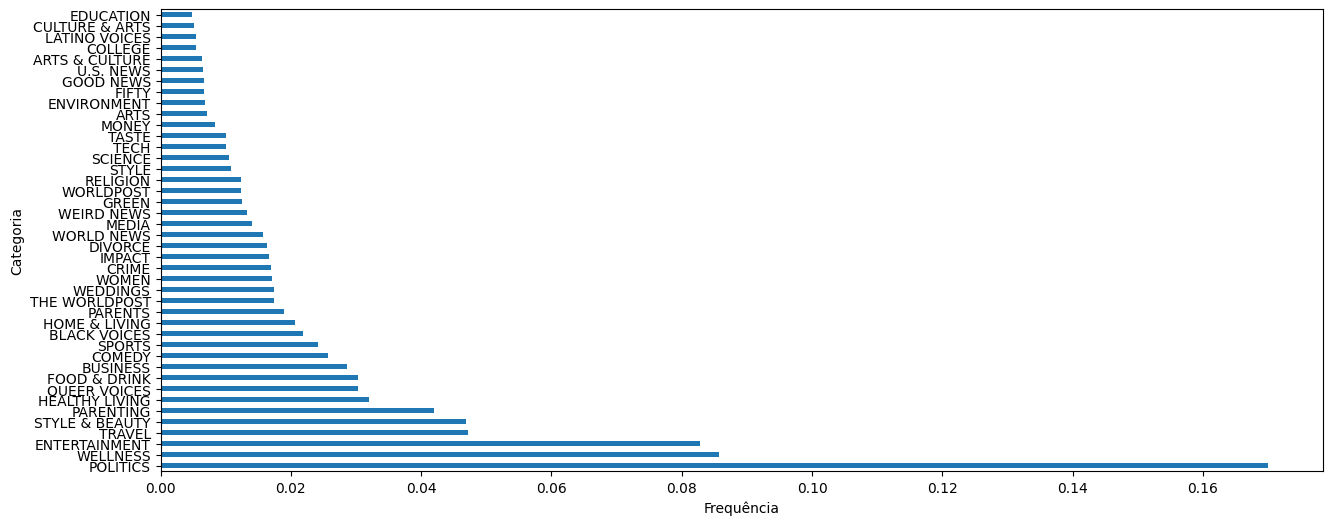

In [7]:
df['category'].value_counts(normalize=True).plot.barh(figsize=(15,6))
plt.ylabel("Categoria")
plt.xlabel("Frequência")
plt.show()

## Pré-Processamento

Combinando a `headline` e a `short_description` em uma única feature.

In [8]:
df['text'] = df['headline'] + " " + df['short_description']

df.head()

,link,headline,category,short_description,authors,date,text
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li..."
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...


# **Baseline Model - Regressão Logística**

Realizaremos a divisão do conjunto de dados em treinamento e teste, mantendo uma proporção de 80/20.

Em seguida realizamos a tokenização do conjunto de dados usando o algoritmo TF-IDF

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr_clf', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr_clf', LogisticRegression(max_iter=1000))])

In [10]:
y_pred = pipeline.predict(X_test)

## Avaliação do Modelo de Regressão Logística


In [11]:
logistic_regression_report = classification_report(y_test, y_pred)

print(logistic_regression_report)

                precision    recall  f1-score   support

          ARTS       0.43      0.18      0.25       293
ARTS & CULTURE       0.41      0.10      0.16       275
  BLACK VOICES       0.52      0.32      0.40       889
      BUSINESS       0.52      0.46      0.49      1216
       COLLEGE       0.48      0.30      0.37       202
        COMEDY       0.55      0.39      0.45      1022
         CRIME       0.54      0.54      0.54       713
CULTURE & ARTS       0.77      0.22      0.34       202
       DIVORCE       0.83      0.65      0.73       664
     EDUCATION       0.49      0.24      0.33       209
 ENTERTAINMENT       0.55      0.79      0.65      3419
   ENVIRONMENT       0.70      0.18      0.28       313
         FIFTY       0.45      0.07      0.12       263
  FOOD & DRINK       0.61      0.74      0.67      1270
     GOOD NEWS       0.55      0.15      0.24       270
         GREEN       0.39      0.29      0.34       532
HEALTHY LIVING       0.43      0.24      0.31  

### Persistência do Modelo com Joblib

In [12]:
import joblib  

joblib.dump(pipeline, '../models/logistic_regression_model.pkl')

['../models/logistic_regression_model.pkl']

# **Naive Bayes com TF-IDF**

### Referências

* 1. Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
* 2. Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).
